In [2]:
from FAdo.fa import *
from FAdo.reex import *
from FAdo.fio import *
from FAdo.rndadfa import *

import lark

In [ ]:
class CPower(Unary):
	def __init__(self, arg, n, sigma=None):
		self.arg = arg
		self.n = n
		self.Sigma = sigma
		self._ewp = False if self.n > 0 else True
		#super(CPower, self).__init__(arg, n)
	
	def __str__(self):
		"""String representation of the regular expression."""
		return '{}^{}'.format(self.arg, self.n)
	
	def __repr__(self):
		"""String representation of the regular expression."""
		return '{}^{}'.format(self.arg, self.n)
	
	def _strP(self):
		"""String representation of the regular expression."""
		return '{}^{}'.format(self.arg, self.n)
	
	def ewp(self):
		return self.n==0

	def linearForm(self):
		arg_lf = self.arg.linearForm()
		#print(arg_lf)
		lf = dict()
		for head in arg_lf:
			lf[head] = set()
			for tail in arg_lf[head]:
				# if tail.emptysetP():
				# 	lf[head].add(CEmptySet(self.Sigma))
				# else:
				if self.n == 0:
					lf[head].add(CEmptySet(self.Sigma))
				elif self.n == 1:
					lf[head].add(CEpsilon(self.Sigma))
				else:
					lf[head].add(CPower(self.arg, self.n-1, self.Sigma))

		return lf

	def partialDerivatives(self, sigma):
		return self.arg.partialDerivatives(sigma)

	def derivative(self, sigma):
		if str(sigma) in str(self.arg):
			if self.n == 0:
				return CEmptySet(sigma)
			elif self.n == 1:
				return self.arg.derivative(sigma)
			else:
				return CConcat(self.arg.derivative(sigma), CPower(self.arg, self.n-1, self.Sigma))
		else:
			return CEmptySet(sigma)

In [4]:
class CCount(Unary):
	def __init__(self, arg, min, max = None, sigma = None):
		self.arg = arg
		self.min = int(min)
		self.max = "inf" if max == -1 or max == "inf" else int(max)-1
		self.Sigma = sigma

		if self.min==0:
			self._ewp = True
	
	def __str__(self):
		"""String representation of the regular expression."""
		return 'CCount({},[{}[)'.format(self.arg, self.min if self.max=="inf" else '{},{}'.format(self.min, self.max+1))
	
	def _strP(self):
		"""String representation of the regular expression."""
		return 'CCount({},[{}[)'.format(self.arg, self.min if self.max=="inf" else '{},{}'.format(self.min, self.max+1))

	def __repr__(self):
		"""Representation of the regular expression's syntactical tree."""
		return 'CCount({},[{}[)'.format(self.arg, self.min if self.max=="inf" else '{},{}'.format(self.min, self.max+1))

	def epsilonP(self):
		if self.max == "inf" or self.max == None:
			return self.min == 0
		else:
			m_v = int(self.max)
			return self.min == 0 and m_v == 0
		
	def ewp(self):
		return self.min==0
	
	def derivative(self, sigma):
		if str(sigma) in str(self.arg) and str(sigma) != "":
			if self.max == "inf" or self.max == None:
				if self.min == 0: # means it was 1 -> [1, ...] -> argder.CStar
					return CConcat(self.arg.derivative(sigma), CStar(self.arg, self.Sigma))
				else:
					return CConcat(self.arg.derivative(sigma), CCount(self.arg, self.min-1, self.max, sigma), self.Sigma)
			else:
				if self.min == 0:
					return CConcat(self.arg.derivative(sigma), CCount(self.arg, self.min, int(self.max), self.Sigma))
				else:
					return CConcat(self.arg.derivative(sigma), CCount(self.arg, self.min-1, int(self.max), self.Sigma))
					
		else:
			return CEmptySet(sigma)

	def partialDerivatives(self, sigma):
		arg_pdset = self.arg.partialDerivatives(sigma)
		pds = set()
		for pd in arg_pdset:
			if pd.emptysetP():
				pds.add(CEmptySet(self.Sigma))
			elif pd.epsilonP():
				pds.add(self)
			else:
				pds.add(CConcat(pd, self, self.Sigma))
		return pds

	def linearForm(self): # https://www.dcc.fc.up.pt/~nam/resources/publica/51480046.pdf
		def nested(values):
			if not values:
				return None
			elif len(values) == 1:
				return values[0]
			else:
				return CDisj(values[0], nested(values[1:]))

		arg_lf = self.arg.linearForm()
		lf = dict()
		for head in arg_lf:
			lf[head] = set()
			for tail in arg_lf[head]:
				if tail.emptysetP():
					lf[head].add(CEmptySet(self.Sigma))
				elif tail.epsilonP():
					if self.max == "inf" or self.max == None:
						if self.min - 1 == 0:
							lf[head].add(CStar(self.arg, self.Sigma))
						else:
							lf[head].add(CConcat(CPower(self.arg, self.min-1, self.Sigma), CStar(self.arg, self.Sigma), self.Sigma))
					else:
						mav = int(self.max)
						lst = []
						for i in range(self.min-1, mav):
							if i > 0:
								lst.append(CPower(self.arg, i, self.Sigma))
							else:
								lst.append(CEpsilon(self.Sigma))

						lf[head].add(nested(lst))
				else:
					if self.max == "inf" or self.max == None:
						if self.min - 1 == 0:
							lf[head].add(CConcat(tail, CStar(self.arg, self.Sigma)))
						else:
							lf[head].add(CConcat(tail, CConcat(CPower(self.arg, self.min-1, self.Sigma), CStar(self.arg, self.Sigma), self.Sigma)))
					else:
						mav = int(self.max)
						lst = []
						for i in range(self.min, mav):
							lst.append(CPower(self.arg, i, self.Sigma))

						lf[head].add(CConcat(tail, nested(lst), self.Sigma))
					
		return lf

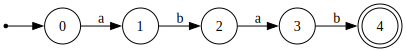

In [175]:

def pow_min(self, s, inf=False):
    (arg, n_r) = s
    n = int(n_r.children[0].value)
    if inf:
        if n == 0:
            r = CStar(arg, sigma=self.sigma)
        else:
            r = CCount(arg, n, -1, sigma=self.sigma)
    else:
        r = CPower(arg, n, sigma=self.sigma)

    # r._ewp = False

    return r

def pow_minmax(self, s):
    (arg, n_mi, n_ma) = s
    n_min = n_mi.children[0].value
    n_max = n_ma.children[0].value
    r = CCount(arg, n_min, n_max, sigma=self.sigma)
    # r._ewp = False
    return r

def pow_inf(self, s):
    return self.pow_min(s, True)

BuildRegexp.pow_inf = pow_inf
BuildRegexp.pow_min = pow_min
BuildRegexp.pow_minmax = pow_minmax

regGrammar = lark.Lark.open("regexp_test.lark", start="rege", parser="lalr")
#tree = regGrammar.parse("((b+a)^[2,5[)")
tree = regGrammar.parse("abab")
reg = BuildRegexp(context={"sigma": None}).transform(tree)
reg.setSigma(reg.setOfSymbols())
reg.toNFA(nfa_method="nfaPDNaive").display()

In [ ]:
start = reg
word = "abab"
sigma = set(word)

def run(auto, sigma):
	print("Running at state: ", auto)
	if auto.emptysetP():
		print("is empty")
		return False
	else:
		for _ in sigma:
			if not run(auto.derivative(sigma), sigma):
				return False

In [183]:
run(start, sigma)

Running at state:  ((a b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running at state:  ((@empty_set b) a) b
Running a

RecursionError: maximum recursion depth exceeded

In [152]:
k=dict()
k['a']=1

In [153]:
class bnt:
	def __init__(self, automata):
		self.branches = dict()
		self.automata = automata
		self.ewp = self.automata.ewp()

	def print_all(self):
		print("A: {} -> EWP: {}".format(self.automata, self.ewp))
		for k, v in self.branches.items():
			print("Branch {}: {}".format(k, v))

	def __str__(self):
		return "A: {} -> EWP: {}".format(self.automata, self.ewp)
		# if not self.branches:
		# 	return str(self.automata)
		# else:
		# 	out = ""
		# 	for i in self.branches:
		# 		out += str(i) + " -> " + str(self.branches[i]) + "\n"
		# 	return out
		
	def _ewp(self):
		if self.branches:
			for i in self.branches:
				#print(self.branches[i])
				return self.branches[i]._ewp()
		else:
			return self.automata.ewp()

	def addNew(self, sigma):
		#print("{} has {}".format(self.automata, len(self.branches)))
		if sigma in self.branches:
			#print("adding {} at {}".format(sigma, self.automata))
			self.branches[sigma].addNew(sigma)
			
		else:
			na = self.automata.derivative(sigma)
			self.branches[sigma] = bnt(na)



In [ ]:
alpha = "ab"
tree = bnt(reg)

# tree.addNew('a')
#print(tree.branches['a'].__str__())
#tree.addNew('b')
#print(tree.branches['b'].__str__())
# tree.addNew('b')

for _ in alpha:
	for a in set(alpha):
		tree.addNew(a)

tree._ewp()

#print(tree.branches['a'].__str__())


#tree._ewp()

True